In [1]:
ref_file="/home/wuyou/Projects/Os_AD/data/transcripts.fasta"
ref_dict={}
with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:].split(" ")[0]
            ref_dict[chr]=""
        else:
            seq=line
            ref_dict[chr]+=seq


In [3]:
#event level features C m5C hm5C

from scipy import interpolate
import traceback
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import re
import numpy as np
from statsmodels import robust

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'


def interp(x):
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()



ref_chr="LOC_Os02g02890.1.MSUv7.0"
#site=133
site=869
normalize="median_mad"

print(ref_dict[ref_chr][site-2:site+3])

X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
X=[]
Y=[]

signal_files=["/home/wuyou/Projects/Os_AD/data/unmod.signal.tsv",
              "/home/wuyou/Projects/Os_AD/data/m5C.signal.tsv",
             "/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.signal.tsv"]

label_dict={0:"AUCAA",1:"AUm5CAA",2:"AUac4CAA"}

for k,signal_file in enumerate(signal_files):
    print(signal_file)
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]

            if chr != ref_chr:
                continue
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)



            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / np.float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]


            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):                                 #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X.append(x)
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>500:
                break
            

print(len(Y))



ATCAA
/home/wuyou/Projects/Os_AD/data/unmod.signal.tsv
/home/wuyou/Projects/Os_AD/data/m5C.signal.tsv
/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.signal.tsv
1503


In [19]:
print(len(x))

ERROR: Error in len(x): could not find function "len"


In [3]:
#save data
data=X_mean
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=["AUCAA"]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_mean.csv")

data=X_std
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=["AUCAA"]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_std.csv")

data=X_median
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=["AUCAA"]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_median.csv")

data=X_length
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=["AUCAA"]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_length.csv")

data=X_base_quality
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=["AUCAA"]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_base_quality.csv")

Registering fonts with R

Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_signif()`).”


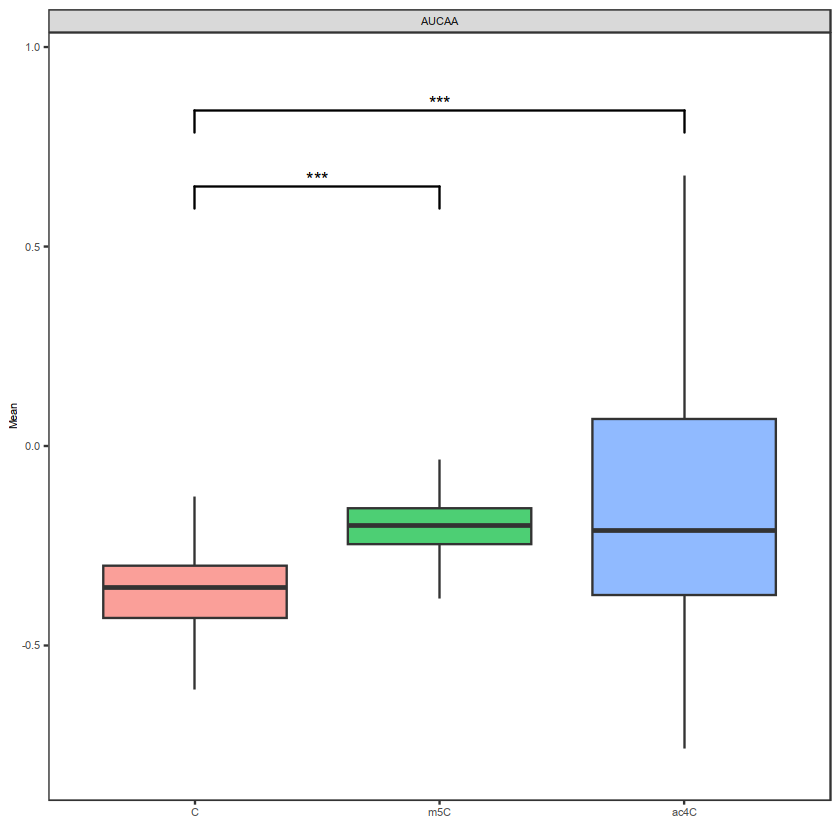

In [1]:
#plot C
library(ggplot2)
library(ggsignif)
library(extrafont)

data=read.csv("data/event_level_features_C_mean.csv", encoding='utf-8')

data$label <- factor(data$label, levels=c("C", "m5C", "ac4C"))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("C", "m5C")),
        map_signif_level = TRUE,
        y_position =0.56,vjust = 0.5
      )+
    geom_signif(
        comparisons = list(c("C", "ac4C")),
        map_signif_level = TRUE,
        y_position = 0.75,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Mean",x = "")+
      ylim(c(-0.8,0.95))+
      facet_wrap(vars(sequence))
        
ggsave("figure/new_event_level_features_C_mean.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)
#dev.off()

Warning message:
“Removed 197 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 197 rows containing non-finite values (`stat_boxplot()`).”


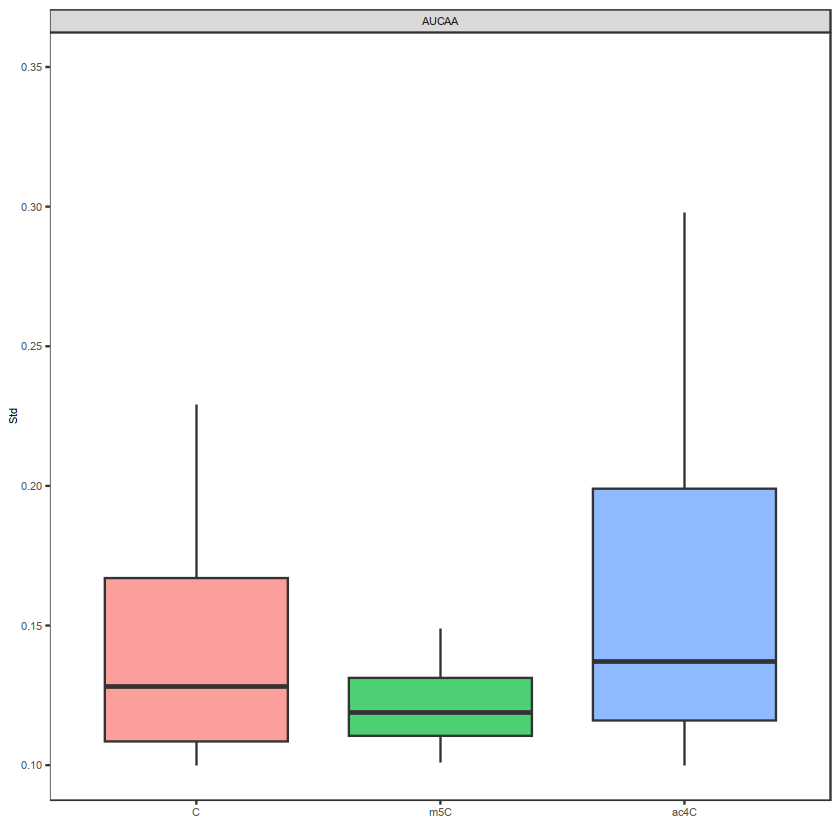

In [8]:
data=read.csv("data/event_level_features_C_std.csv", encoding='utf-8')


data$label <- factor(data$label, levels=c("C", "m5C", "ac4C"))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Std",x = "")+
      ylim(c(0.1,0.35))+
      facet_wrap(vars(sequence))
        
ggsave("figure/new_event_level_features_C_std.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)
#dev.off()

Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 2 rows containing non-finite values (`stat_signif()`).”


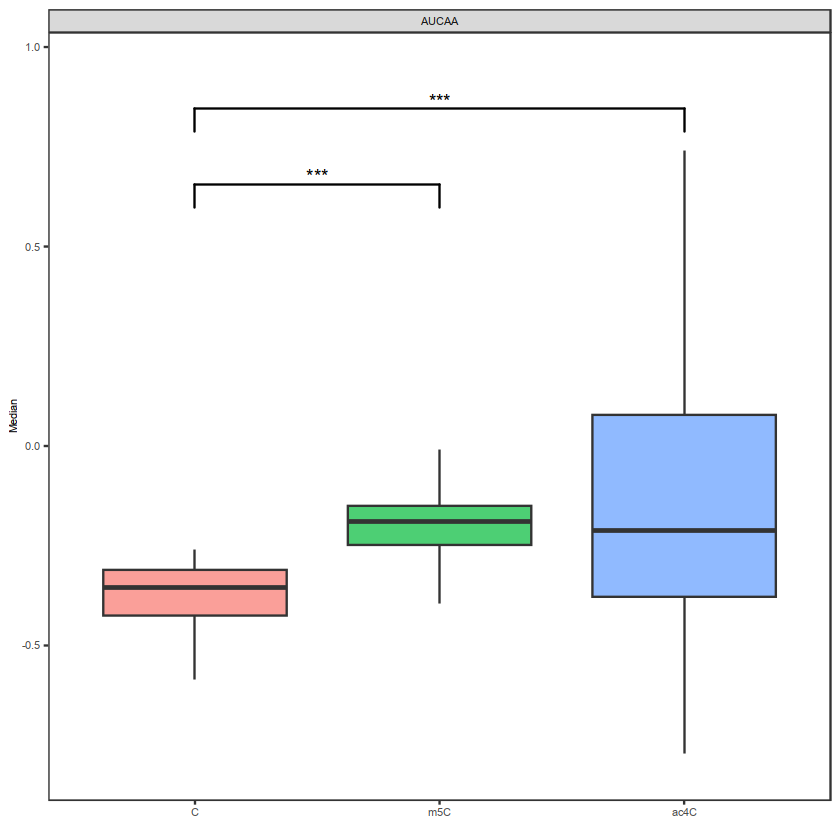

In [10]:
data=read.csv("data/event_level_features_C_median.csv", encoding='utf-8')
data$label <- factor(data$label, levels=c("C", "m5C", "ac4C"))
ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("C", "m5C")),
        map_signif_level = TRUE,
        y_position =0.56,vjust = 0.5
      )+
    geom_signif(
        comparisons = list(c("C", "ac4C")),
        map_signif_level = TRUE,
        y_position = 0.75,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Median",x = "")+
      ylim(c(-0.8,0.95))+
      facet_wrap(vars(sequence))
        
ggsave("figure/new_event_level_features_C_median.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)
#dev.off()

Warning message:
“Removed 6 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_signif()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_signif()`).”


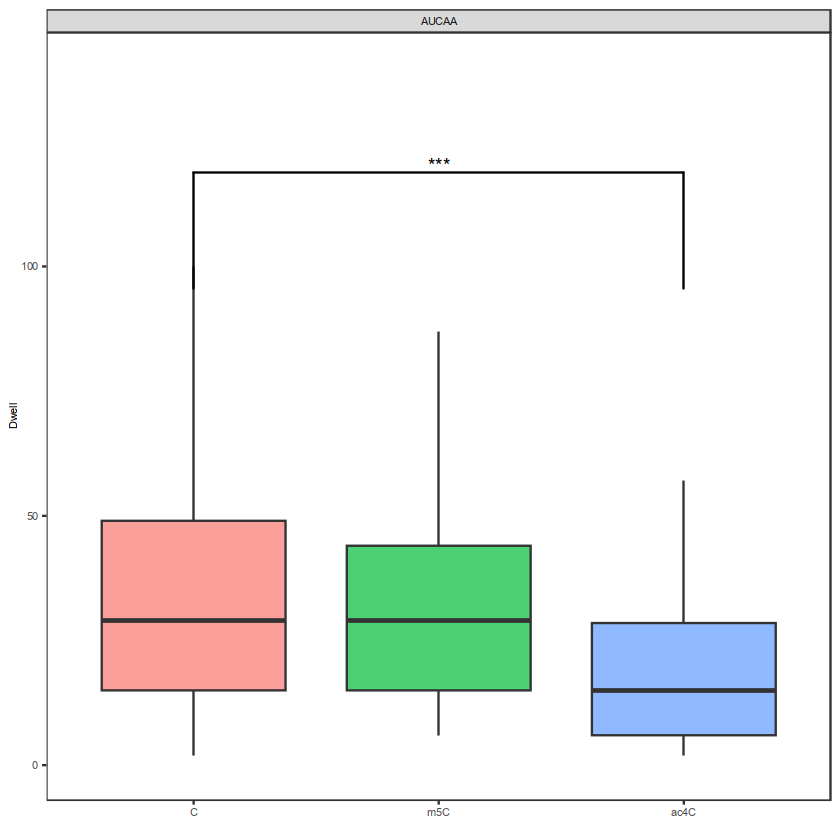

In [15]:
data=read.csv("data/event_level_features_C_length.csv", encoding='utf-8')
data$label <- factor(data$label, levels=c("C", "m5C", "ac4C"))
ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    geom_signif(
        comparisons = list(c("C", "ac4C")),
        map_signif_level = TRUE,
        y_position = 80,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Dwell",x = "")+
      ylim(c(0,140))+
      facet_wrap(vars(sequence))
        
ggsave("figure/new_event_level_features_C_length.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)
#dev.off()

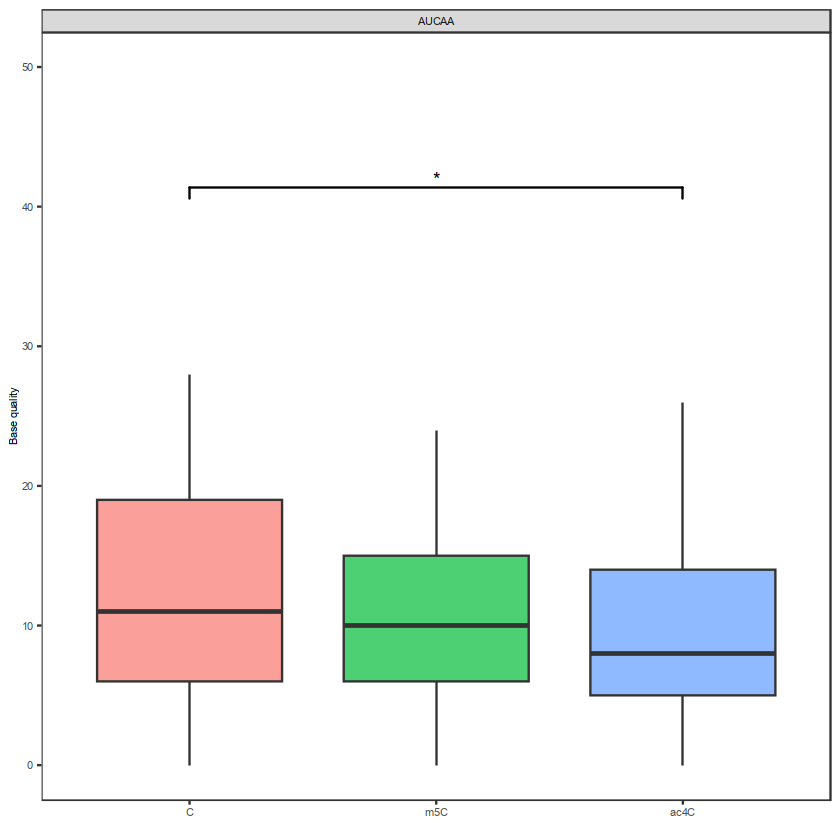

In [18]:
data=read.csv("data/event_level_features_C_base_quality.csv", encoding='utf-8')
data$label <- factor(data$label, levels=c("C", "m5C", "ac4C"))
ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    geom_signif(
        comparisons = list(c("C", "ac4C")),
        map_signif_level = TRUE,
        y_position = 40,vjust = 0.5
    )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Base quality",x = "")+
      ylim(c(0,50))+
      facet_wrap(vars(sequence))
        
ggsave("figure/new_event_level_features_C_base_quality.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)
#dev.off()

In [2]:

depth_dict={}

signal_files=["/home/wuyou/Projects/Os_AD/data/unmod.signal.tsv",
              "/home/wuyou/Projects/Os_AD/data/m5C.signal.tsv",
             "/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.signal.tsv"]

for i,signal in enumerate(signal_files):
    with open(signal) as f:
        for line in f:
            contig=line.split("\t")[1]
            if contig not in depth_dict:
                depth_dict[contig]=[0,0,0]
            depth_dict[contig][i]+=1


    

In [3]:
for contig in depth_dict:
    print(contig,depth_dict[contig])

LOC_Os11g47330.1.MSUv7.0 [1144, 490, 38]
LOC_Os06g46770.5.MSUv7.0 [212, 55, 6]
LOC_Os04g20880.1.MSUv7.0 [117, 48, 0]
LOC_Os06g46284.2.MSUv7.0 [151, 67, 3]
LOC_Os12g23200.2.MSUv7.0 [372, 155, 297]
LOC_Os12g16010.1.MSUv7.0 [2599, 746, 12]
LOC_Os01g15270.1.MSUv7.0 [8770, 5523, 2053]
LOC_Os01g41710.1.MSUv7.0 [6413, 3547, 8074]
LOC_Os01g18640.2.MSUv7.0 [85, 33, 2]
LOC_Os05g31140.1.MSUv7.0 [1360, 406, 20]
LOC_Os07g03279.1.MSUv7.0 [1251, 3185, 13020]
LOC_Os04g33680.1.MSUv7.0 [231, 58, 0]
LOC_Os11g06440.1.MSUv7.0 [725, 89, 9]
LOC_Os04g53950.3.MSUv7.0 [402, 211, 22]
LOC_Os03g08360.3.MSUv7.0 [150, 92, 61]
LOC_Os01g03680.1.MSUv7.0 [881, 945, 202]
LOC_Os03g55830.1.MSUv7.0 [606, 687, 22]
LOC_Os02g55120.1.MSUv7.0 [118, 84, 21]
LOC_Os03g16150.1.MSUv7.0 [1008, 213, 37]
LOC_Os02g47570.2.MSUv7.0 [128, 7, 0]
LOC_Os09g00999.1.MSUv7.0 [2822, 853, 264]
LOC_Os03g50355.1.MSUv7.0 [108, 29, 5]
LOC_Os03g46770.1.MSUv7.0 [29091, 5481, 5644]
LOC_Os08g08360.1.MSUv7.0 [291, 213, 48]
LOC_Os03g15730.1.MSUv7.0 [1022, 38

In [2]:
#gene count from sam file

with open("/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.sam") as f:
    gene_dict={}
    for line in f:
        if line[0]=="@":
            continue
        gene=line.split("\t")[2]
        if gene not in gene_dict:
            gene_dict[gene]=0
        gene_dict[gene]+=1

#write to txt file
with open("data/gene_count_IVT_ac4C.txt","w") as f:
    for gene in gene_dict:
        f.write(gene+"\t"+str(gene_dict[gene])+"\n")